In [1]:
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from collections import Counter
from utils import (
    visualize_images,
    verify_image_sizes,
    plot_bar,
    create_conditioning_distribution,
    create_conditioning_vector,
    show_generated,
    to_uint8,
    measure_fid,
    visualize_images_grid
)
from vae import VAE, train_vae
from diffusion_model import UNet, train_diffusion, generate
from gan import GAN, train_gan

In [2]:
basic_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3) ])
dataset = datasets.ImageFolder("data/trafic_32", transform=basic_transforms)

In [3]:
analysis_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=14)
classes = dataset.classes
print("Class count:",len(classes))

Class count: 43


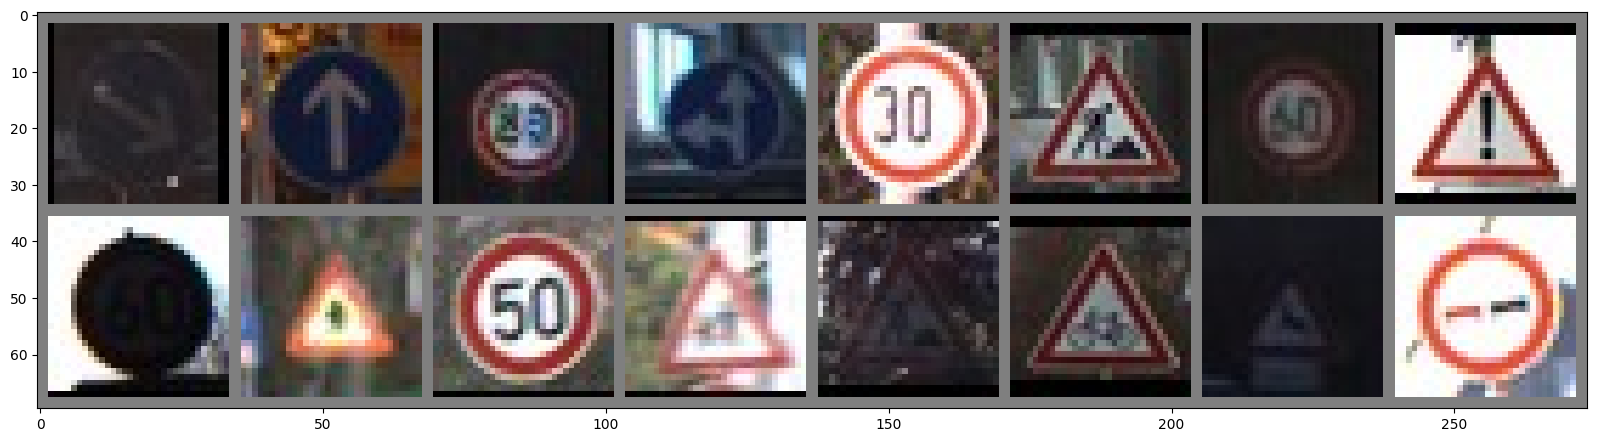

00038 00035 00005 00037 00001 00025 00003 00018 00003 00011 00002 00028 00025 00029 00031 00009


In [4]:
visualize_images(analysis_loader, classes, figsize=(20, 10))

We see that the images are correctly loaded and all have the same size (3, 32, 32).

In [5]:
verify_image_sizes(analysis_loader)

{torch.Size([3, 32, 32]): 39209}

We check the dataset classes distribution to get as close to the test set distribution as possible (for better FID).

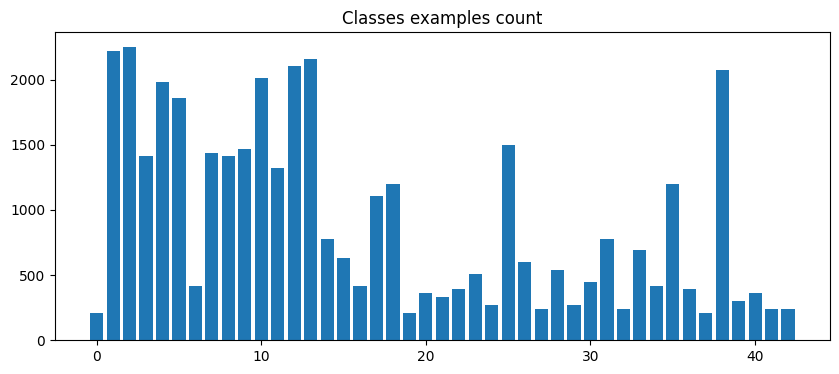

In [6]:
class_examples_num = dict(Counter(dataset.targets))
plot_bar(class_examples_num, "Classes examples count",  size=(10, 4))

In [7]:
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=14, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training
We created three conditional models with different architectures to compare their performance:
- VAE
- Diffusion Model
- GAN
Each one of them was trained with the same hyperparameters:
- epochs = 200
- learning rate = 1e-4
- batch size = 64
## Training the conditional VAE model

In [8]:
vae = VAE(input_dim=3, hidden_dims=[32, 64, 128, 2048, 512], latent_dim=128, num_classes=43, label_emb_dim=32, device=device).to(device)

In [38]:
print("VAE model summary:")
print(vae)

VAE model summary:
VAE(
  (encoder): Encoder(
    (blocks): Sequential(
      (0): Sequential(
        (0): Conv2d(35, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
      )
      (3): Sequential(
        (0): Flatten(start_dim=1, end_dim=-1)
        (1): Linear(in_features=2048, out_features=512, bias=True)
      )
    )
    (mu): Linear(in_features=512, out_features=128, bias=True)
    (var): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (blocks): Sequential(
      (0): Sequential(
        (0): Linear(in_features=160, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=2048, bias=True)
        (3): Unflatten(dim=1, un

In [9]:
vae.load("weights/vae.pth")
train_vae(vae, device, train_dataloader, epochs=100, lr=1e-4)


[Epoch 001] | loss: 5718.3222
[Epoch 002] | loss: 5613.6956
[Epoch 003] | loss: 5578.1342
[Epoch 004] | loss: 5552.8741
[Epoch 005] | loss: 5537.8633
[Epoch 006] | loss: 5524.1816
[Epoch 007] | loss: 5512.7330
[Epoch 008] | loss: 5503.2541
[Epoch 009] | loss: 5495.7987
[Epoch 010] | loss: 5488.3424
[Epoch 011] | loss: 5481.6854
[Epoch 012] | loss: 5475.4233
[Epoch 013] | loss: 5470.4071
[Epoch 014] | loss: 5466.5817
[Epoch 015] | loss: 5463.8244
[Epoch 016] | loss: 5457.6792
[Epoch 017] | loss: 5453.7011
[Epoch 018] | loss: 5452.2247
[Epoch 019] | loss: 5446.3860
[Epoch 020] | loss: 5446.1267
[Epoch 021] | loss: 5445.7686
[Epoch 022] | loss: 5436.4512
[Epoch 023] | loss: 5440.3199
[Epoch 024] | loss: 5434.9665
[Epoch 025] | loss: 5431.6276
[Epoch 026] | loss: 5429.6295
[Epoch 027] | loss: 5429.0130
[Epoch 028] | loss: 5423.9264
[Epoch 029] | loss: 5423.7225
[Epoch 030] | loss: 5421.1118
[Epoch 031] | loss: 5418.6931
[Epoch 032] | loss: 5415.6798
[Epoch 033] | loss: 5416.3068
[Epoch 034

## Training the conditional Diffusion model

In [10]:
diff_model = UNet(input_ch=3, base_ch=64, timestep_emb=128, num_classes=43, label_emb_dim=32).to(device)

In [39]:
print("Diffusion model summary:")
print(diff_model)

Diffusion model summary:
UNet(
  (label_embedding): LabelEmbedding(
    (embedding): Embedding(43, 32)
  )
  (timestep_embedding): SinusoidalTimeEmbedding()
  (emb_proj): Sequential(
    (0): Linear(in_features=160, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1): ResBlock(
    (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): GroupNorm(8, 128, eps=1e-05, affine=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act): SiLU()
    (emb_proj): Linear(in_features=128, out_features=128, bias=True)
    (skip_connection): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (down2): ResBlock(
    (norm1): GroupNorm(8, 128, eps=1e-05, affine=True)
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1)

In [11]:
diff_model.load("weights/ddpm.pth")
train_diffusion(diff_model, train_dataloader, epochs=100, lr=1e-4, device=device)


[Epoch 001] | loss: 0.0203
[Epoch 002] | loss: 0.0202
[Epoch 003] | loss: 0.0203
[Epoch 004] | loss: 0.0199
[Epoch 005] | loss: 0.0207
[Epoch 006] | loss: 0.0206
[Epoch 007] | loss: 0.0198
[Epoch 008] | loss: 0.0199
[Epoch 009] | loss: 0.0201
[Epoch 010] | loss: 0.0199
[Epoch 011] | loss: 0.0195
[Epoch 012] | loss: 0.0203
[Epoch 013] | loss: 0.0198
[Epoch 014] | loss: 0.0200
[Epoch 015] | loss: 0.0203
[Epoch 016] | loss: 0.0198
[Epoch 017] | loss: 0.0200
[Epoch 018] | loss: 0.0201
[Epoch 019] | loss: 0.0199
[Epoch 020] | loss: 0.0201
[Epoch 021] | loss: 0.0203
[Epoch 022] | loss: 0.0197
[Epoch 023] | loss: 0.0195
[Epoch 024] | loss: 0.0202
[Epoch 025] | loss: 0.0195
[Epoch 026] | loss: 0.0199
[Epoch 027] | loss: 0.0202
[Epoch 028] | loss: 0.0195
[Epoch 029] | loss: 0.0196
[Epoch 030] | loss: 0.0201
[Epoch 031] | loss: 0.0193
[Epoch 032] | loss: 0.0195
[Epoch 033] | loss: 0.0194
[Epoch 034] | loss: 0.0197
[Epoch 035] | loss: 0.0197
[Epoch 036] | loss: 0.0198
[Epoch 037] | loss: 0.0193
[

## Training the conditional GAN model

In [12]:
gan = GAN(input_dim=3, hidden_dims=[512, 256, 128, 64], latent_dim=128, num_classes=43, label_emb_dim=32, device=device).to(device)

In [40]:
print("GAN model summary:")
print(gan)

GAN model summary:
GAN(
  (generator): Generator(
    (proj): Sequential(
      (0): Linear(in_features=160, out_features=8192, bias=True)
      (1): ReLU()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (2): Sequential(
        (0): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): Tanh()
      )
    )
  )
  (discriminator): Discriminator(
    (blocks): Sequential(
      (0): Sequential(
        (0): Conv2d(35, 64, kernel_size=(4, 4), stride=(2, 2), 

In [13]:
gan.load("weights/gan.pth")
train_gan(gan, device, train_dataloader, epochs=150, lr=1e-4)

[Epoch 001] discriminator loss: 0.5038 | generator loss: 2.9035
[Epoch 002] discriminator loss: 0.4982 | generator loss: 2.9661
[Epoch 003] discriminator loss: 0.5022 | generator loss: 2.9169
[Epoch 004] discriminator loss: 0.5027 | generator loss: 2.9622
[Epoch 005] discriminator loss: 0.4933 | generator loss: 2.9715
[Epoch 006] discriminator loss: 0.5140 | generator loss: 2.9578
[Epoch 007] discriminator loss: 0.5011 | generator loss: 2.9581
[Epoch 008] discriminator loss: 0.5034 | generator loss: 2.9070
[Epoch 009] discriminator loss: 0.5139 | generator loss: 2.8835
[Epoch 010] discriminator loss: 0.5117 | generator loss: 2.8880
[Epoch 011] discriminator loss: 0.5020 | generator loss: 2.9103
[Epoch 012] discriminator loss: 0.5085 | generator loss: 2.8762
[Epoch 013] discriminator loss: 0.5000 | generator loss: 2.9383
[Epoch 014] discriminator loss: 0.5062 | generator loss: 2.9477
[Epoch 015] discriminator loss: 0.5147 | generator loss: 2.9445
[Epoch 016] discriminator loss: 0.5012 |

We mirror the original training dataset distribution for conditioning vector (1000 samples) to better match the test set data.

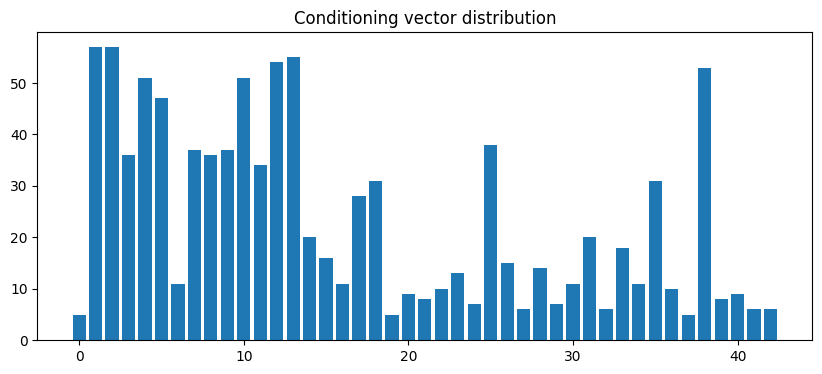

In [25]:
cond_distr = create_conditioning_distribution(dataset, sample_size=1000)
conditioning_vector = create_conditioning_vector(cond_distr)
plot_bar(cond_distr , "Conditioning vector distribution",  size=(10, 4))

### Generated images VAE

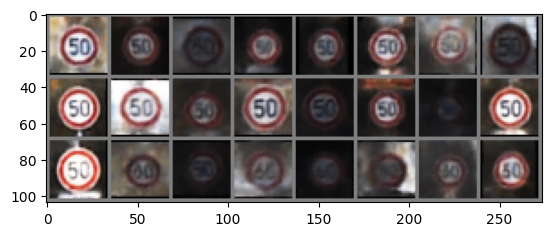

In [28]:
generated_images_vae = vae.generate(torch.Tensor(conditioning_vector).long().to(device))
show_generated(generated_images_vae, 100, 124)


In [27]:
generated_images_diff = generate(diff_model, conditioning_vector.to(device))

### Generated images diffusion

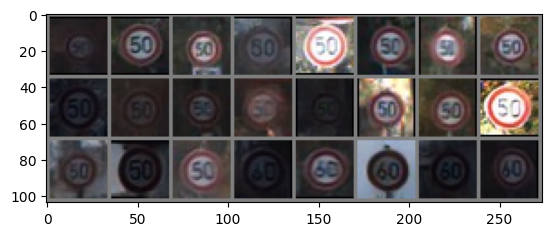

In [29]:
show_generated(generated_images_diff.detach().cpu(), 100, 124)

### GAN generation
With GAN network we can see the phenomenon of "mode collapse". For some classes the generator learnt to produce identical samples, because it discovered that these few “easy” modes consistently fool the current discriminator

In [30]:
generated_images_gan = gan.generate(torch.Tensor(conditioning_vector).long().to(device))

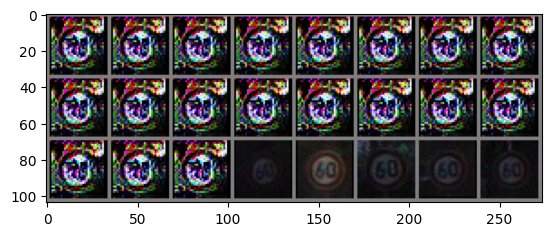

In [31]:
show_generated(generated_images_gan.detach().cpu(), 100, 124)

### Comparison of different models generation (random class labels)

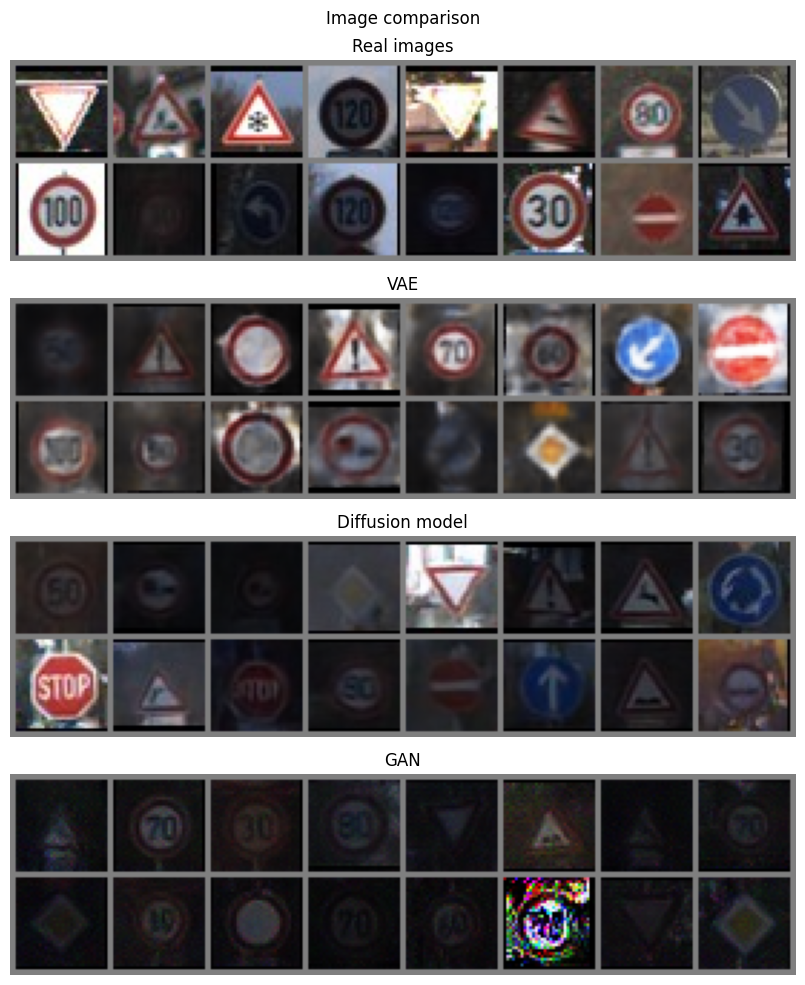

In [32]:
images = {"Real images": dataset, "VAE": generated_images_vae, "Diffusion model": generated_images_diff, "GAN": generated_images_gan}

visualize_images_grid(images, figsize=(20, 10), title="Image comparison")


## FID comparison
We calculate the FID between the real dataset and 1000 generated images for every model. Diffusion model achieved the best results by far.

In [34]:
fid_vae = measure_fid(dataset, generated_images_vae, device)
fid_diff = measure_fid(dataset, generated_images_diff, device)
fid_gan = measure_fid(dataset, generated_images_gan, device)
df = pd.DataFrame({"Model": ["VAE", "Diffusion", "GAN"], "FID": [fid_vae, fid_diff, fid_gan]})

In [35]:
df

,Model,FID
0,VAE,80.929077
1,Diffusion,31.002338
2,GAN,173.356003


In [36]:
best_generated_images = generated_images_diff

### Denormalize and verify before saving

In [37]:
generated_images = to_uint8(best_generated_images)
print("Min:", generated_images.min().item())
print("Max:", generated_images.max().item())
print("Generated images shape:", generated_images.shape)
print("Generated images dtype:", generated_images.dtype)
torch.save(generated_images.detach().cpu(), "piatek_szymanska_szymczyk.pt")

Min: 0
Max: 255
Generated images shape: torch.Size([1000, 3, 32, 32])
Generated images dtype: torch.uint8


## Conclusion
- Diffusion model achieved the best performance out of the three tested architectures.
- All models learnt to be conditioned on input vectors.
- Diffusion model's images are the most sharp, and similar to the real samples.
- VAE model's images are also mostly good, but some examples seem blurry.
- Because of mode collapse the GAN model produces many examples of very bad quality. Those that are better are mostly very dark. 
- Inference process in GAN and VAE is almost instant, while with diffusion model it takes about 4-5 minutes for 1000 examples.